## Modele

Dane niezbędne do prawidłowego funkcjonowania modelu przygotowywane są dzięki wykorzystaniu mechanizmu `pipeline` z biblioteki `sklearn`. Do wyboru cech (proces ich wybierania przebiega analogicznie jak ten zdefiniowany w *preprocessing_02.ipynb*) służy klasa **FeatureBuilder**. Następnie atrybuty są odpowiednio przetwarzane przez **Preprocessor** - uzupełnia on brakujące wartości i koduje atrybuty. 

Sprawdzone modele to:
1. Model bazowy - **Regresja liniowa**
2. Model docelowy - **Las losowy**

W procesie trenowania modelu używana jest metoda **walidacji krzyżowej**.

#### Setup

In [44]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from sklearn.pipeline import Pipeline
from src.builder import FeatureBuilder
from src.preprocessor import Preprocessor

#### Wczytanie i przygotwanie odpowiednich danych do pipeline'u ML i ewaluacji modelu 

In [46]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import HDBSCAN
from src.transformations.target import transform_pipeline
import numpy as np

listings = pd.read_csv("../data/listings.csv")
sessions = pd.read_csv("../data/sessions.csv")
target = transform_pipeline(listings["price"])
listings.drop(columns=["price"], inplace=True)

coords_rad = np.radians(listings[["latitude", "longitude"]].to_numpy())
clusterer = HDBSCAN(
    min_cluster_size=15,
    min_samples=1,
    metric="haversine",
    cluster_selection_method="eom",
    copy=False,
)
ids = clusterer.fit_predict(coords_rad)

X = listings
y = target
cv = KFold(n_splits=5, shuffle=True, random_state=13)

#### Model bazowy - regresja liniowa

In [47]:
from sklearn.linear_model import LinearRegression

pipe_linear = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", LinearRegression()),
    ]
)

cv_scores = cross_val_score(pipe_linear, X, y, cv=cv, scoring="neg_mean_squared_error")
mse = -cv_scores

pipe_linear.fit(X, y)

print(f"Mean CV MSE (linear model): {mse.mean():.4f} ± {mse.std():.4f}")

Mean CV MSE (linear model): 0.1154 ± 0.0065


#### Model docelowy - random forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

pipe_random_forest = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", RandomForestRegressor(n_jobs=-1)),
    ]
)

param_grid = {
    "regressor__n_estimators": [50, 100, 150, 200, 300],
    "regressor__max_depth": [None, 10, 20, 30],
    "regressor__min_samples_split": [2, 5, 8, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=pipe_random_forest,
    param_grid=param_grid,
    cv=cv,  
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=0,
    refit=True
)

grid_search.fit(X, y)

mse = -grid_search.best_score_
params = grid_search.best_params_

print(f"Best mean CV MSE (random forest) : {mse:.4f}")
print(f"Chosen parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   1.8s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   1.8s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   1.9s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   1.7s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   2.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   2.0s
[CV] END regressor__max_depth=None, regressor__min_samples_

/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python

[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=250; total time=   2.7s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   3.2s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=250; total time=   2.7s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=250; total time=   2.8s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=250; total time=   3.9s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   2.6s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estima

/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python

[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=250; total time=   2.6s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=250; total time=   2.5s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=200; total time=   3.0s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=200; total time=   3.0s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=250; total time=   3.1s


/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python

[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=250; total time=   3.0s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=250; total time=   3.0s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   3.0s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=8, regressor__n_estimators=50; total time=   1.9s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=8, regressor__n_estimators=50; total time=   2.4s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   2.7s
[CV] END regressor__max_depth=15, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=300; total 

/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/michau/Studies/IUM/.venv/lib64/python

[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=250; total time=   2.4s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=250; total time=   2.3s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=250; total time=   2.2s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=200; total time=   2.6s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=250; total time=   2.4s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=250; total time=   3.2s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10, regressor__n_estimators=30

/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/model_selection/_validation.py:927: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/model_selection/_validation.py", line 916, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/metrics/_scorer.py", line 317, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michau/Studies/IUM/.venv/lib64/python3.14/site-packages/sklearn/metrics/_scorer.py", line 409, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/michau/Studies/IUM/.

PicklingError: Could not pickle the task to send it to the workers.

W tym przypadku las losowy wykazuje bardzo małą wrażliwość na strojenie hiperparametrów. Mimo to, wybrane zostały najlepsze, być może wpłyną one pozytywnie na model. 

### Interpretacja wyników

#### Wykresy różnicy ceny danej i przewidzianej:
- Zielona belka - mediana dla klastra
- Środkowa sztabka - 50% środkowych wartości
- Knoty świec - skrajne predykcje

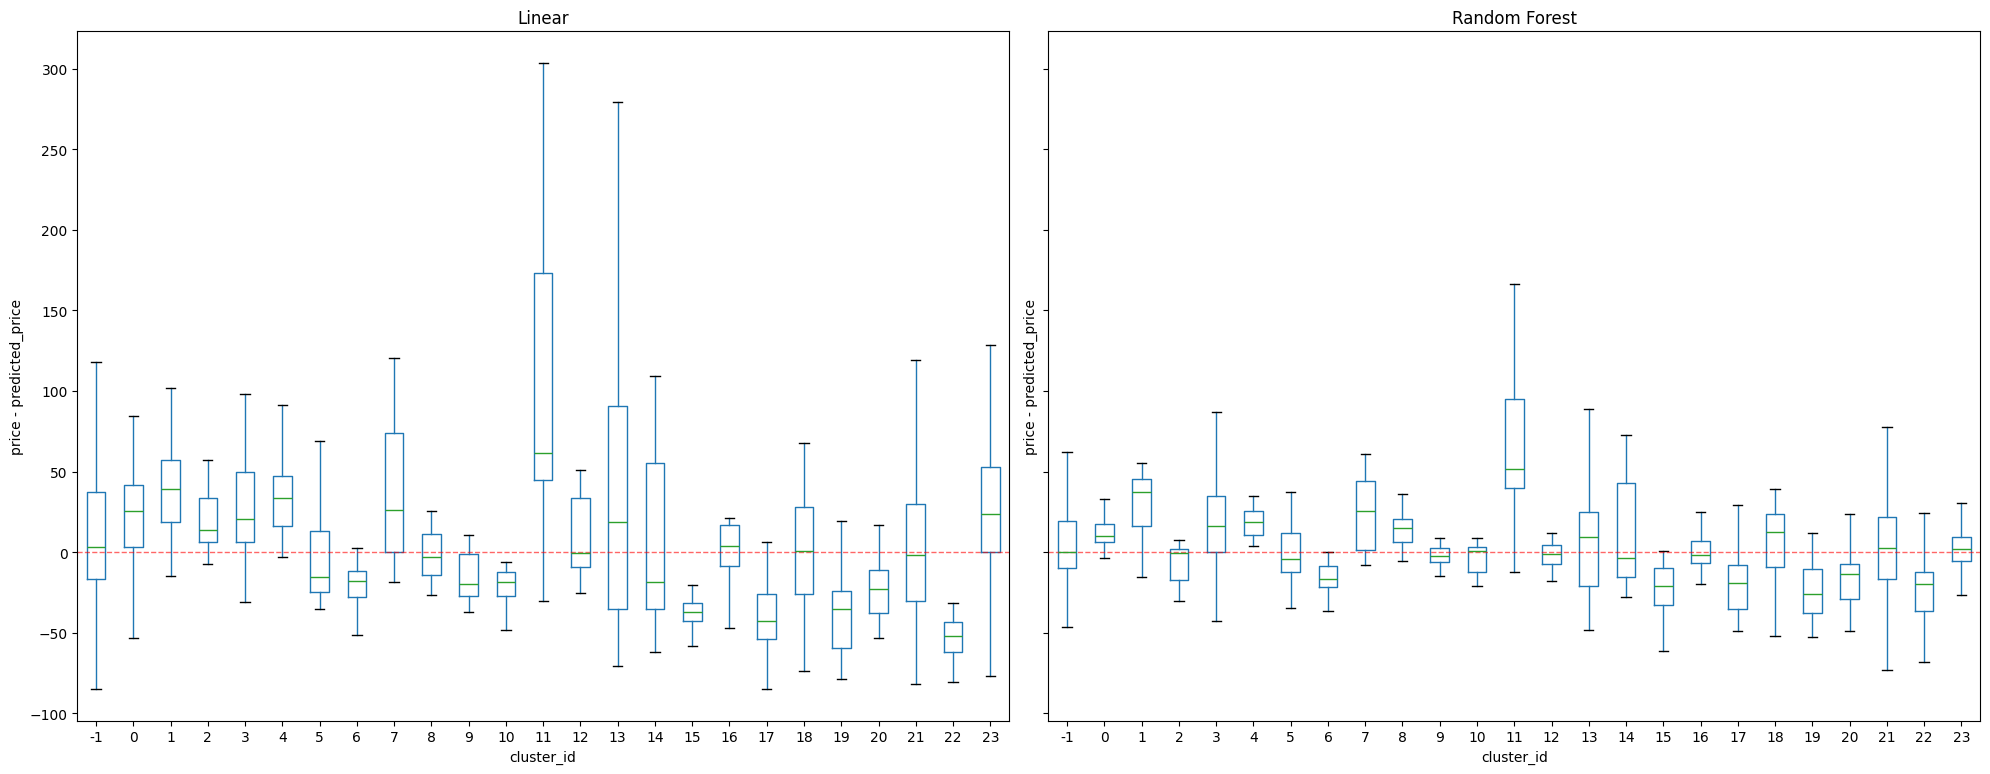

In [ ]:
from src.visualizations.results import visualize_results_compare, visualize_map

pred_linear = pipe_linear.predict(X)
pred_rf = grid_search.best_estimator_.predict(X)

diff_linear = np.expm1(y) - np.expm1(pred_linear)
diff_rf = np.expm1(y) - np.expm1(pred_rf)
visualize_results_compare(diff_linear, diff_rf, ids)

Interpretacja map
- Kolor zielony - zbyt mało ofert w regionie
- Kolor czerwony - zbyt dużo ofert w regionie

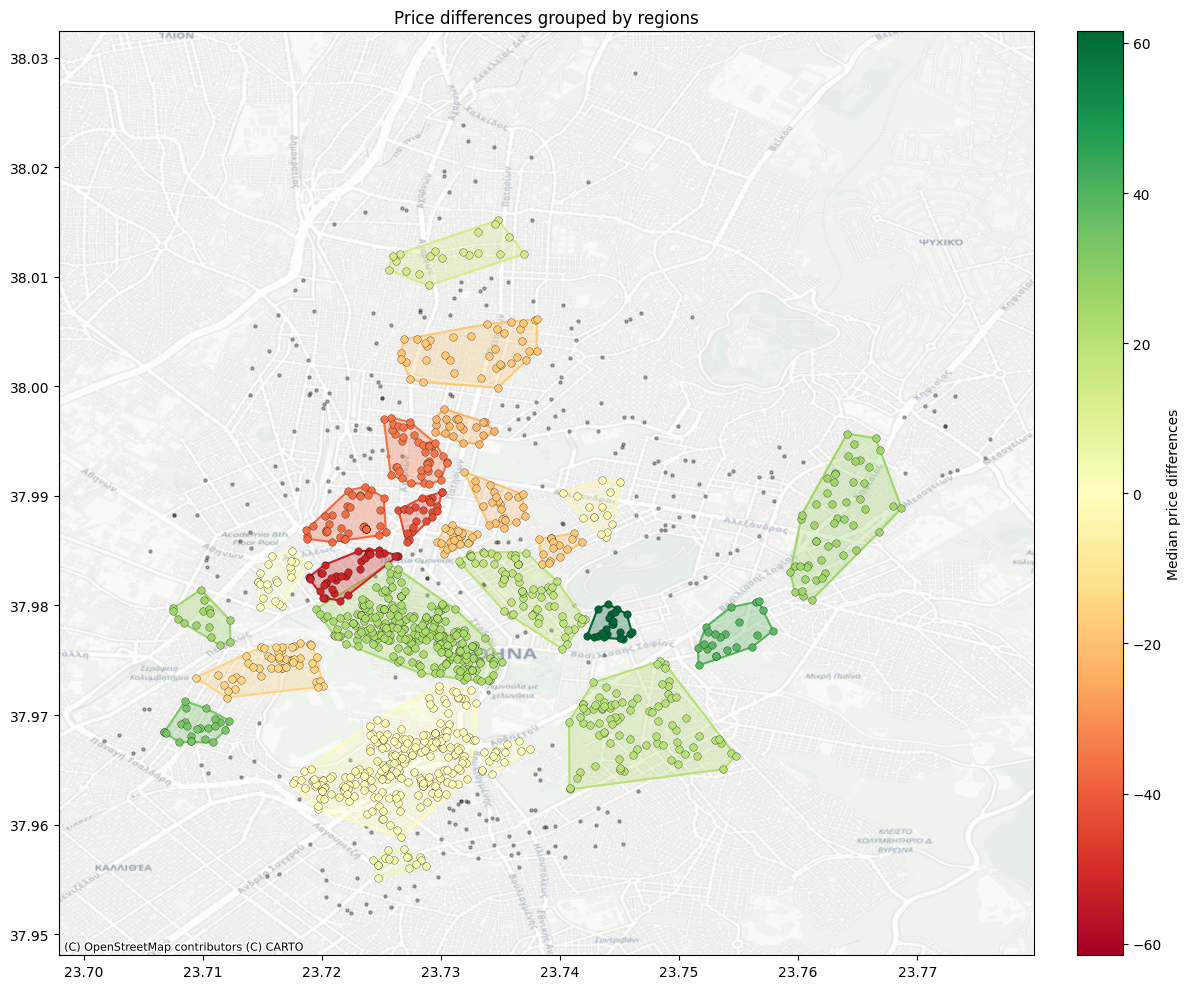

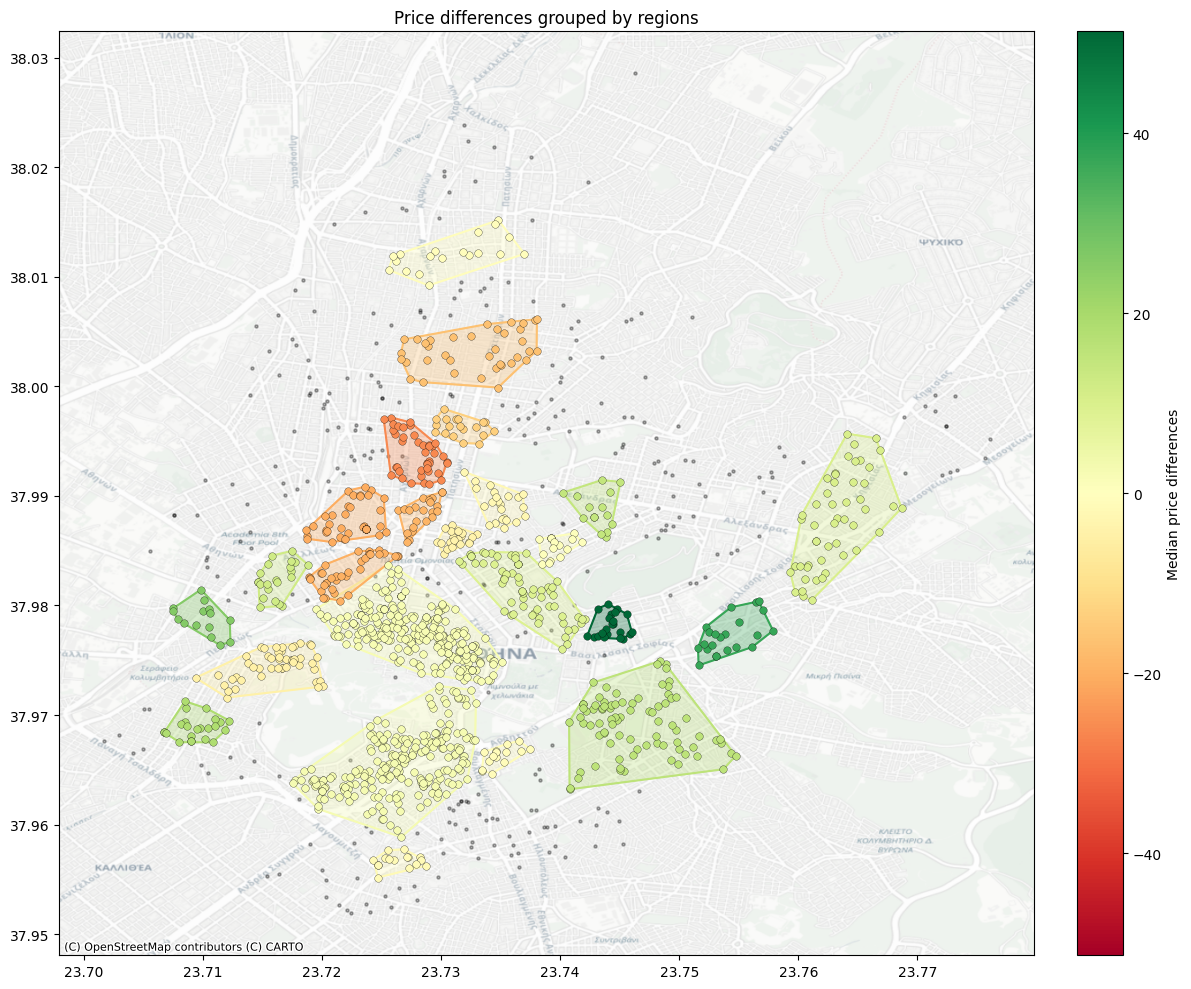

In [ ]:
visualize_map(diff_linear, ids, listings)
visualize_map(diff_rf, ids, listings)

## Wnioski

1. **Błąd MSE** podczas uczenia modelu - różnica wartości między błędu między modelami jest niewielka. Nie mówi jasno czy stosowanie lasu losowego jest konieczne.
2. **Mapy** - wyniki dla obydwu modeli są stosunkowo podobne, trzeba się dobrze przyjrzeć, żeby zobaczyć różnicę.
3. **Wykresy statystyczne** - znacząco różnią się od siebie. Dla modelu regresji liniowej wyniki są bardziej skrajne, model nie jest w stanie wychwycić nieliniowych zależności, co prowadzi do bardzo dużych różnic predykcji w obrębie jednego klastra. Natomiast wyniki lasu losowego są bardziej stabilne, jest on w stanie dostrzec trudniejsze zależności, co przekłada się na mniej zaszumione wyniki.

Obserwacje wskazują, że w analizowanym problemie szukania regionów, w których liczba ofert jest zbyt duża **jest adekwatne** zastosowanie bardziej zaawansowanego modelu **lasu losowego**.

## Feature importance

Wartości *feature importance* zostaną wyciągnięte z pipeline'u modelu lasu losowego.

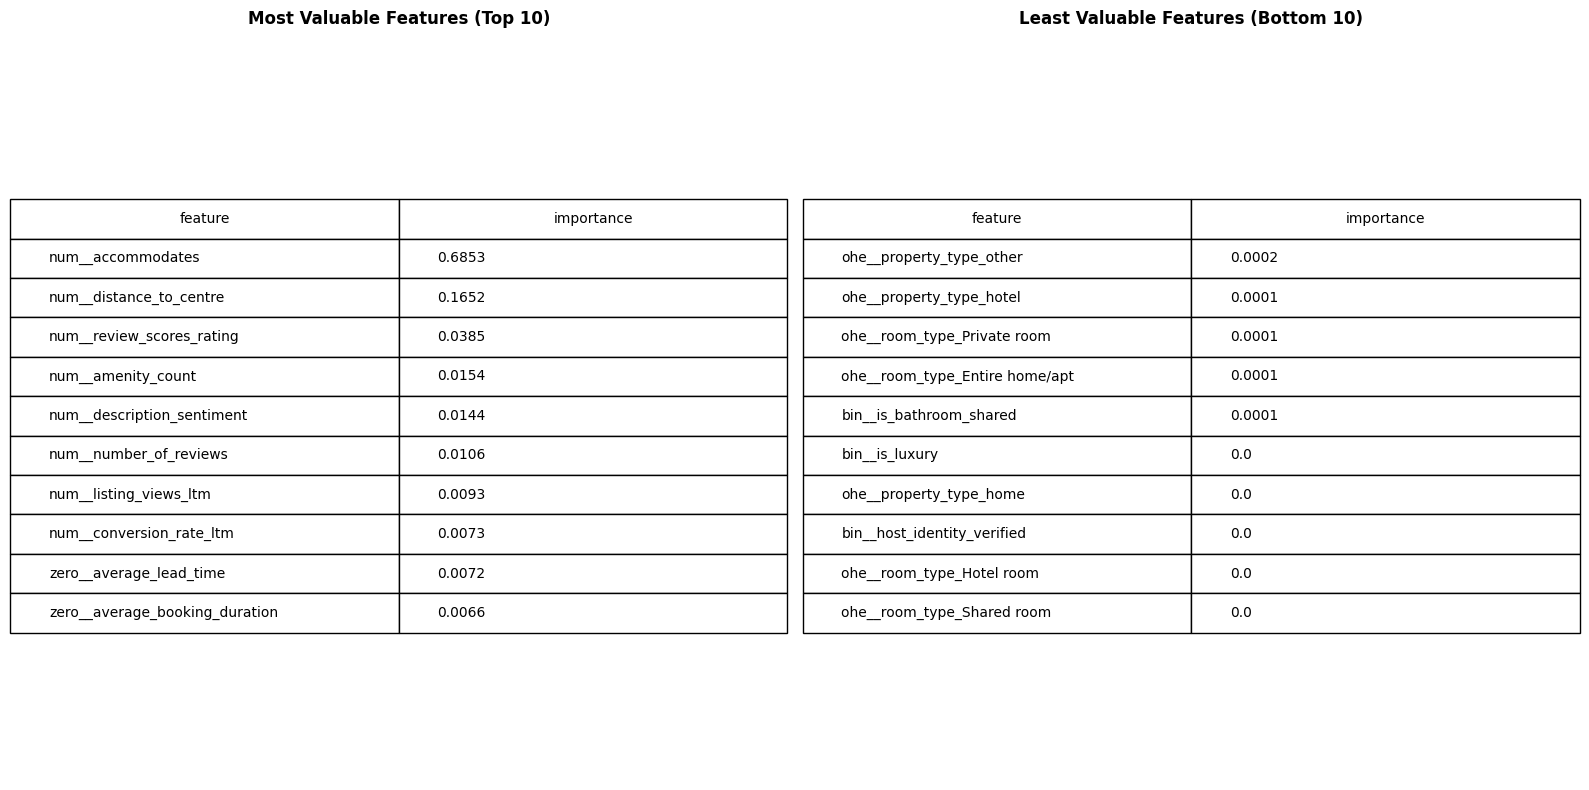

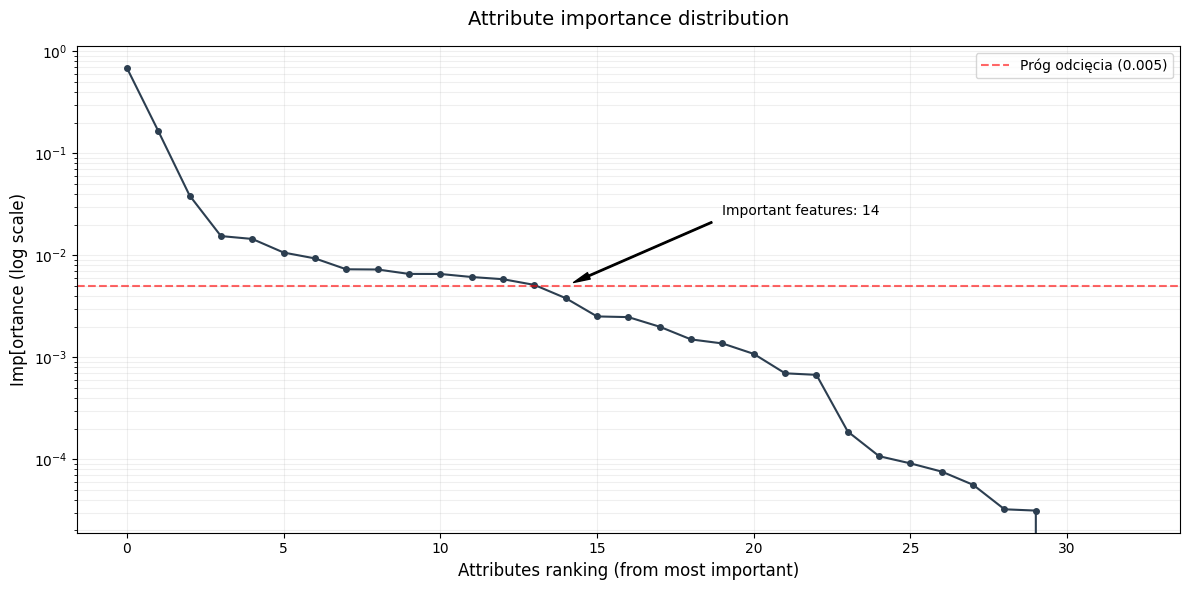

In [ ]:
from src.visualizations.feature_importance import visualize_feature_importance_tables, plot_importance_distribution

visualize_feature_importance_tables(grid_search.best_estimator_)
plot_importance_distribution(grid_search.best_estimator_)